Interpolated V_G values at I_D = 1e-5 A (within linear region):
   1X PBS baseline (V_G @ I_D=1e-5)  100 pM befD (V_G @ I_D=1e-5)
0                          0.617587                      0.650276
1                          0.617345                      0.654068
2                               NaN                      0.656061
3                               NaN                      0.658289
4                               NaN                      0.653980
5                               NaN                      0.649470


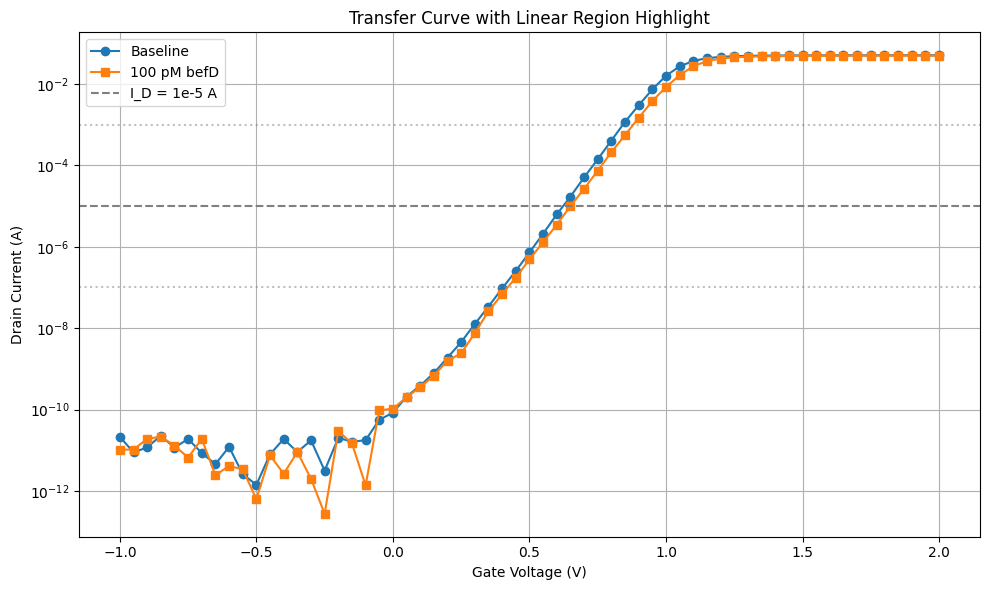

Baseline mean V_G @ I_D=1e-5 A: 0.6175 V
Delta V values (100 pM - mean baseline):
  Replicate 1: ΔV = 0.0328 V
  Replicate 2: ΔV = 0.0366 V
  Replicate 3: ΔV = 0.0386 V
  Replicate 4: ΔV = 0.0408 V
  Replicate 5: ΔV = 0.0365 V
  Replicate 6: ΔV = 0.0320 V

Mean ΔV: 0.0362 V
Std Dev ΔV: 0.0034 V


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load Excel File ===
file_path = r"C:\Users\chris\OneDrive\Desktop\Book1.xlsx"  # <-- Update path here
df = pd.read_excel(file_path, header=None)

# === Extract structure ===
labels = df.iloc[0]
gate_v = df.iloc[2:, 0].astype(float).values
data = df.iloc[2:].astype(float)

# === Define your groups ===
baseline_cols = labels[labels == '1X PBS baseline'].index
target_cols = labels[labels == '100 pM befD'].index

# === Target Current and Linear Region Limits ===
target_ID = 1e-5
ID_min, ID_max = 1e-7, 1e-3  # define linear region

# === Interpolation Function within Linear Region ===
def interpolate_vg(gate_v, id_curve, target_current, ID_min, ID_max):
    # Restrict to linear region
    mask = (id_curve >= ID_min) & (id_curve <= ID_max)
    gate_v_lin = gate_v[mask]
    id_curve_lin = id_curve[mask]
    
    for i in range(1, len(id_curve_lin)):
        if id_curve_lin[i - 1] < target_current <= id_curve_lin[i]:
            x0, x1 = gate_v_lin[i - 1], gate_v_lin[i]
            y0, y1 = id_curve_lin[i - 1], id_curve_lin[i]
            return x0 + (target_current - y0) * (x1 - x0) / (y1 - y0)
    return np.nan

# === Interpolate each replicate ===
baseline_vgs = [interpolate_vg(gate_v, data[col].values, target_ID, ID_min, ID_max) for col in baseline_cols]
target_vgs = [interpolate_vg(gate_v, data[col].values, target_ID, ID_min, ID_max) for col in target_cols]

# === Convert to DataFrame ===
baseline_series = pd.Series(baseline_vgs, name="1X PBS baseline (V_G @ I_D=1e-5)")
target_series = pd.Series(target_vgs, name="100 pM befD (V_G @ I_D=1e-5)")
result_df = pd.concat([baseline_series, target_series], axis=1)

# === Save results (optional) ===
output_path = r"C:\Users\chris\OneDrive\Desktop\VG_shifts_filtered.xlsx"  # <-- Update path if needed
result_df.to_excel(output_path, index=False)

# === Display result ===
print("Interpolated V_G values at I_D = 1e-5 A (within linear region):")
print(result_df)

# === Optional: Plot one example to verify filtering ===
i = 0  # index of the replicate to plot
id_baseline = data[baseline_cols[i]].astype(float).values
id_target = data[target_cols[i]].astype(float).values

plt.figure(figsize=(10, 6))
plt.semilogy(gate_v, id_baseline, 'o-', label='Baseline')
plt.semilogy(gate_v, id_target, 's-', label='100 pM befD')
plt.axhline(target_ID, color='gray', linestyle='--', label='I_D = 1e-5 A')
plt.axhline(ID_min, color='gray', linestyle=':', alpha=0.5)
plt.axhline(ID_max, color='gray', linestyle=':', alpha=0.5)
plt.xlabel("Gate Voltage (V)")
plt.ylabel("Drain Current (A)")
plt.title("Transfer Curve with Linear Region Highlight")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 1: Compute mean V_G for baseline
baseline_mean_vg = np.nanmean(baseline_vgs)

# === Step 2: Compute delta V for each 100 pM replicate
delta_Vs = [vg - baseline_mean_vg if not np.isnan(vg) else np.nan for vg in target_vgs]

# === Step 3: Compute mean and std of delta V
delta_V_mean = np.nanmean(delta_Vs)
delta_V_std = np.nanstd(delta_Vs, ddof=1)  # sample std

# === Step 4: Print results
print(f"Baseline mean V_G @ I_D=1e-5 A: {baseline_mean_vg:.4f} V")
print("Delta V values (100 pM - mean baseline):")
for i, dv in enumerate(delta_Vs):
    print(f"  Replicate {i+1}: ΔV = {dv:.4f} V" if not np.isnan(dv) else f"  Replicate {i+1}: ΔV = NaN")

print(f"\nMean ΔV: {delta_V_mean:.4f} V")
print(f"Std Dev ΔV: {delta_V_std:.4f} V")



In [7]:
### Start from here ###
import pandas as pd
import numpy as np

def compute_delta_VG_at_ID(
    file_path,
    baseline_label='1X PBS baseline',
    target_label='100 pM befD',
    target_ID=1e-5,
    ID_min=1e-7,
    ID_max=1e-3,
    gate_col=0,
    header_rows=2,
    label_row=0
):
    """
    Interpolates VG at a given ID for two groups in a spreadsheet and computes delta V.

    Returns:
        delta_Vs: list of ΔV values (target - baseline_mean)
        delta_V_mean: mean of ΔV
        delta_V_std: standard deviation of ΔV
        baseline_VGs: interpolated VG for each baseline replicate
        target_VGs: interpolated VG for each target replicate
    """

    # Load and parse Excel
    df = pd.read_excel(file_path, header=None)
    labels = df.iloc[label_row]
    gate_v = df.iloc[header_rows:, gate_col].astype(float).values
    data = df.iloc[header_rows:].astype(float)

    # Column indices for each group
    baseline_cols = labels[labels == baseline_label].index
    target_cols = labels[labels == target_label].index

    # Interpolation function (linear, within linear region)
    def interpolate_vg(gate_v, id_curve, target_ID, ID_min, ID_max):
        mask = (id_curve >= ID_min) & (id_curve <= ID_max)
        gate_v_lin = gate_v[mask]
        id_curve_lin = id_curve[mask]
        for i in range(1, len(id_curve_lin)):
            if id_curve_lin[i - 1] < target_ID <= id_curve_lin[i]:
                x0, x1 = gate_v_lin[i - 1], gate_v_lin[i]
                y0, y1 = id_curve_lin[i - 1], id_curve_lin[i]
                return x0 + (target_ID - y0) * (x1 - x0) / (y1 - y0)
        return np.nan

    # Interpolate for each replicate
    baseline_VGs = [interpolate_vg(gate_v, data[col].values, target_ID, ID_min, ID_max) for col in baseline_cols]
    target_VGs = [interpolate_vg(gate_v, data[col].values, target_ID, ID_min, ID_max) for col in target_cols]

    # Compute ΔV
    baseline_mean_vg = np.nanmean(baseline_VGs)
    delta_Vs = [vg - baseline_mean_vg if not np.isnan(vg) else np.nan for vg in target_VGs]
    delta_V_mean = np.nanmean(delta_Vs)
    delta_V_std = np.nanstd(delta_Vs, ddof=1)

    return {
        "delta_Vs": delta_Vs,
        "delta_V_mean": delta_V_mean,
        "delta_V_std": delta_V_std,
        "baseline_VGs": baseline_VGs,
        "target_VGs": target_VGs,
        "baseline_mean_VG": baseline_mean_vg
    }


In [9]:
result = compute_delta_VG_at_ID(
    file_path=r"C:\Users\chris\OneDrive\Desktop\Book1.xlsx",
    baseline_label='baseline aftD-2',
    target_label='100 pM aftD'
)

# Print result
print(f"Baseline mean V_G: {result['baseline_mean_VG']:.4f} V")
print("ΔV values:")
for i, dv in enumerate(result['delta_Vs']):
    print(f"  Replicate {i+1}: ΔV = {dv:.4f} V" if not np.isnan(dv) else f"  Replicate {i+1}: NaN")
print(f"\nMean ΔV: {result['delta_V_mean']:.4f} V")
print(f"Std Dev ΔV: {result['delta_V_std']:.4f} V")


Baseline mean V_G: -0.0994 V
ΔV values:
  Replicate 1: ΔV = 0.6089 V
  Replicate 2: ΔV = 0.5999 V
  Replicate 3: ΔV = 0.5883 V
  Replicate 4: ΔV = 0.5615 V
  Replicate 5: ΔV = 0.5599 V

Mean ΔV: 0.5837 V
Std Dev ΔV: 0.0222 V
